In [2]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
model_data = pd.read_csv('../../data/modeling/modeling_file.csv')
model_data.head()

,TEAM_A,TEAM_B,YEAR,WEEK_NUM,RESULT,TEAM_A_ELO,TEAM_B_ELO,HOME_FIELD,TEAM_A_KM_TRAVELED,TEAM_A_TZ_TRAVELED
0,Arizona Cardinals,Los Angeles Rams,1991-1992,1,1,1500.0,1500.0,0,553.672248,0
1,Atlanta Falcons,Kansas City Chiefs,1991-1992,1,0,1500.0,1500.0,0,1079.388631,100
2,Buffalo Bills,Miami Dolphins,1991-1992,1,1,1500.0,1500.0,1,0.000000,0
3,Chicago Bears,Minnesota Vikings,1991-1992,1,1,1500.0,1500.0,1,0.000000,0
4,Cincinnati Bengals,Denver Broncos,1991-1992,1,0,1500.0,1500.0,0,1764.027331,200


In [3]:
model_data.columns

Index(['TEAM_A', 'TEAM_B', 'YEAR', 'WEEK_NUM', 'RESULT', 'TEAM_A_ELO',
       'TEAM_B_ELO', 'HOME_FIELD', 'TEAM_A_KM_TRAVELED', 'TEAM_A_TZ_TRAVELED'],
      dtype='object')

In [35]:
x_train, x_test, y_train, y_test = train_test_split(model_data.loc[:,[  'WEEK_NUM', 'TEAM_A_ELO', 'TEAM_B_ELO', 'HOME_FIELD','TEAM_A_KM_TRAVELED', 'TEAM_A_TZ_TRAVELED']],
                                                    model_data['RESULT'], test_size=0.25, random_state=123)

In [36]:
## Instantiate LogisticRegression model
logistic_regression = LogisticRegression()

In [37]:
## Train model
logistic_regression.fit(x_train, y_train)

LogisticRegression()

In [38]:
y_pred = logistic_regression.predict(x_test)

In [39]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1321,  789],
       [ 756, 1324]], dtype=int64)

In [40]:
metrics.confusion_matrix(y_train, logistic_regression.predict(x_train))

array([[3965, 2305],
       [2287, 4013]], dtype=int64)

Text(0.5, 427.9555555555555, 'Predicted label')

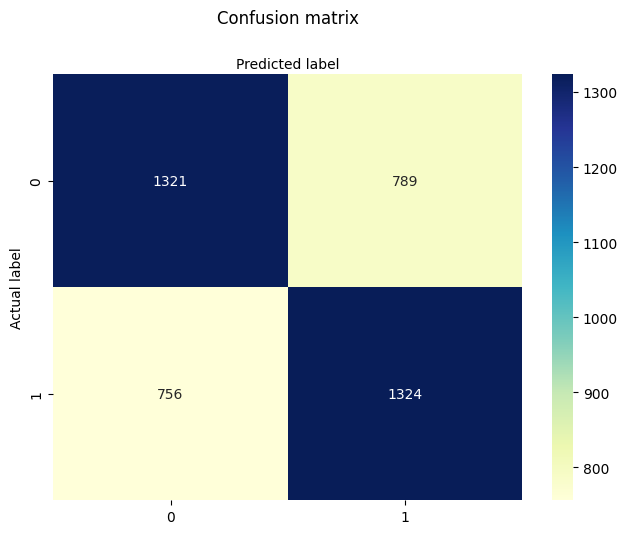

In [41]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


In [42]:
from sklearn.metrics import classification_report
target_names = ['Loss','Win']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        Loss       0.64      0.63      0.63      2110
         Win       0.63      0.64      0.63      2080

    accuracy                           0.63      4190
   macro avg       0.63      0.63      0.63      4190
weighted avg       0.63      0.63      0.63      4190



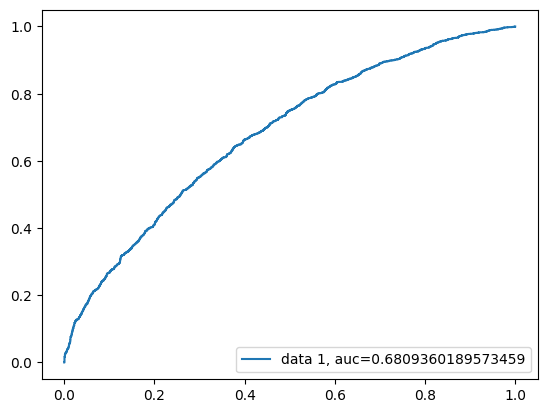

In [43]:
y_pred_proba = logistic_regression.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [44]:
full_data   = model_data.loc[:,[  'WEEK_NUM', 'TEAM_A_ELO','TEAM_B_ELO', 'HOME_FIELD','TEAM_A_KM_TRAVELED', 'TEAM_A_TZ_TRAVELED']]
full_target = model_data['RESULT']

full_pred = logistic_regression.predict(full_data)


In [54]:
from sklearn.metrics import classification_report
target_names = ['Loss','Win']
print(classification_report(full_target, full_pred, target_names=target_names))

              precision    recall  f1-score   support

        Loss       0.63      0.63      0.63      8380
         Win       0.63      0.64      0.63      8380

    accuracy                           0.63     16760
   macro avg       0.63      0.63      0.63     16760
weighted avg       0.63      0.63      0.63     16760



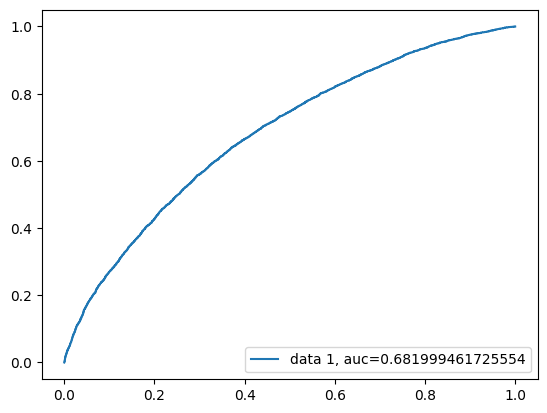

In [45]:
y_pred_proba = logistic_regression.predict_proba(full_data)[::,1]
fpr, tpr, _ = metrics.roc_curve(full_target,  y_pred_proba)
auc = metrics.roc_auc_score(full_target, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [46]:
for x in y_pred_proba[-32:]:
    print(x)

0.36170781128779866
0.5988809813604665
0.7436278020613764
0.6853649287334833
0.41447169095106173
0.38307163626648427
0.5709365827673121
0.43690700493871526
0.5486082962773529
0.5216373135267345
0.1994197210095056
0.6288517635741047
0.262171622746452
0.5674494187427158
0.44375323732195987
0.8029186088285347
0.4900547586455153
0.5918507601625838
0.4095295676150505
0.40701789057294696
0.6175839267418545
0.488223481099813
0.5940278733491949
0.4537608251305804
0.3222148564809711
0.5188343406691241
0.4898968133501887
0.5036385820595527
0.5963479248529366
0.3839406960165056
0.41453129765662106
0.6408057044404695


In [49]:
df_to_predict = pd.read_csv('../../data/modeling/predict_next_week.csv')
df_to_predict.head()

,TEAM_A,TEAM_B,YEAR,WEEK_NUM,TEAM_A_ELO,TEAM_B_ELO,HOME_FIELD,TEAM_A_KM_TRAVELED,TEAM_A_TZ_TRAVELED
0,Minnesota Vikings,Philadelphia Eagles,2023-2024,2,1503.637844,1539.332773,0,1587.362566,-100
1,Green Bay Packers,Atlanta Falcons,2023-2024,2,1513.203441,1451.719682,0,1233.934982,-100
2,Las Vegas Raiders,Buffalo Bills,2023-2024,2,1461.014692,1545.094810,0,3193.872906,-300
3,Baltimore Ravens,Cincinnati Bengals,2023-2024,2,1496.905936,1524.744956,0,682.047010,0
4,Seattle Seahawks,Detroit Lions,2023-2024,2,1468.978885,1462.540255,0,3119.153482,-300


In [52]:
y_pred_proba = logistic_regression.predict_proba(df_to_predict.loc[:,[  'WEEK_NUM', 'TEAM_A_ELO','TEAM_B_ELO', 'HOME_FIELD','TEAM_A_KM_TRAVELED', 'TEAM_A_TZ_TRAVELED']])[::,1]

In [53]:
for x in y_pred_proba:
    print(x)

0.3574737452935004
0.5394992913239698
0.2745807586184481
0.3748198854051643
0.4301601767499056
0.4968220009094574
0.659445826367894
0.4372333229599297
0.23880528427326342
0.46938264626255716
0.5653161202737695
0.2560198482932596
0.5336985538662379
0.4483094678039101
0.5471595568566705
0.393379962876832
0.6433207143485211
0.4663402572447857
0.722711953590025
0.6301084046362432
0.5703184295486774
0.5166421104248127
0.3421147246333281
0.5642069360101241
0.7669504324814377
0.5347826320478013
0.4397108459766681
0.7464333638245617
0.4730357998494801
0.5555223067197129
0.4618619265686036
0.6160148195350905


In [1]:
----------------------------------------

SyntaxError: invalid syntax (812893942.py, line 1)

In [28]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sklearn import metrics

In [33]:
classifiers = [
    LogisticRegression(n_jobs=4),
    KNeighborsClassifier(3, n_jobs=4),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=2, C=1, probability=True),
    #GaussianProcessClassifier(1.0 * RBF(1.0), n_jobs=5),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, n_jobs=4),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

names = [
    "Logistic Regression",
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    #"Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]


In [36]:
model_data = pd.read_csv('../../data/modeling/modeling_file.csv')
model_data.head()

X_train, X_test, y_train, y_test = train_test_split(model_data.loc[:,[  'WEEK_NUM', 'TEAM_A_ELO', 'TEAM_B_ELO', 'HOME_FIELD','TEAM_A_KM_TRAVELED', 'TEAM_A_TZ_TRAVELED']],
                                                    model_data['RESULT'], test_size=0.20, random_state=123)

In [37]:
# iterate over classifiers
for name, clf in zip(names, classifiers):

    clf = make_pipeline(StandardScaler(), clf)
    clf.fit(X_train, y_train)
    
    ## Accuracy
    acc_score = clf.score(X_test, y_test)
    
    ## AUC
    y_pred_proba = clf.predict_proba(X_test)[::,1]
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    print(f"{name}: \n\t> Accuracy: {acc_score:.2%} \n\t> AUC     : {auc:.2%}")
    print()

Logistic Regression: 
	> Accuracy: 63.07% 
	> AUC     : 68.03%

Nearest Neighbors: 
	> Accuracy: 57.16% 
	> AUC     : 59.20%

Linear SVM: 
	> Accuracy: 62.65% 
	> AUC     : 68.01%

RBF SVM: 
	> Accuracy: 61.01% 
	> AUC     : 63.70%

Decision Tree: 
	> Accuracy: 62.32% 
	> AUC     : 66.86%

Random Forest: 
	> Accuracy: 61.87% 
	> AUC     : 66.77%

Neural Net: 
	> Accuracy: 62.92% 
	> AUC     : 68.04%

AdaBoost: 
	> Accuracy: 62.62% 
	> AUC     : 67.25%

Naive Bayes: 
	> Accuracy: 61.52% 
	> AUC     : 66.33%

QDA: 
	> Accuracy: 62.02% 
	> AUC     : 66.69%

